# Setup

Importing libraries:

In [1]:
import gc
gc.enable()

import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    TunedThresholdClassifierCV,
    StratifiedKFold
)
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    make_scorer, 
    fbeta_score, 
    recall_score,
    accuracy_score,
    confusion_matrix
)

Importing processed datasets:

In [2]:
DATA_DIR = '../Dataset/processed'

train = pd.read_csv(f'{DATA_DIR}/train.csv')
test = pd.read_csv(f'{DATA_DIR}/test.csv')

In [3]:
train.shape, test.shape

((9000, 14), (1000, 14))

# Data preparation

In [4]:
TARGET = 'Machine failure'

In [5]:
features = [f for f in train.columns if f != TARGET]

In [6]:
categorical_features = [
    'Type', 
    'temp_diff_above_threshold', 
    'power_out_of_range', 
    'strain_below_11k', 
    'strain_above_12k'
]

numerical_features = [f for f in features if f not in categorical_features]

In [7]:
reduced_features = [f for f in features if f not in 
                    ('Type', 'air_temp_celsius', 'process_temp_celsius', 'power')]

# Modeling framework

In [8]:
def fit_model(classifier, feature_set):
    fbeta = make_scorer(fbeta_score, beta=2)
    skf = StratifiedKFold(n_splits=9, shuffle=True, random_state=0)

    scaler = StandardScaler()
    model_pipeline = make_pipeline(scaler, classifier)

    tuned_model = TunedThresholdClassifierCV(
        estimator=model_pipeline,
        scoring=fbeta,
        response_method='auto',
        thresholds=100,
        cv=skf,
        refit=True,
        n_jobs=-1,
        random_state=0
    ).fit(train[feature_set], train[TARGET])

    n_iter = tuned_model.estimator_[1].n_iter_
    losses = tuned_model.estimator_[1].loss_curve_
    scores = tuned_model.estimator_[1].validation_scores_
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 3))
    ax[0].set_title("Validation loss")
    sns.lineplot(x=range(n_iter), y=losses, ax=ax[0], color='red')
    ax[1].set_title("Validation accuracy")
    sns.lineplot(x=range(n_iter), y=scores, ax=ax[1], color='blue')
    plt.show()

    return tuned_model

In [9]:
def evaluate_model(model, feature_set):
    predictions = model.predict(test[feature_set])
    
    accuracy = accuracy_score(test[TARGET], predictions)
    recall = recall_score(test[TARGET], predictions)
    f2 = fbeta_score(test[TARGET], predictions, beta=2)
    print(f'Accuracy: {accuracy:.4f}\nF2-score: {f2:.4f}\nRecall:   {recall:.4f}\n')
    
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.set_title('Normalized Confusion Matrix')
    sns.heatmap(
        data=confusion_matrix(test[TARGET], predictions, normalize='true'),
        annot=True, fmt='.4f', linewidths=0.1, cmap=plt.cm.Blues
    )
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.show()

In [10]:
def save_model(model, model_config, notebook='06'):
    MODEL_DIR = 'saved_models'
    save_path = f'{MODEL_DIR}/{notebook}_{model_config}.joblib'
    joblib.dump(model, save_path)

# Multi-layer Perceptron (MLP)

### Configuration - 1

In [11]:
classifier = MLPClassifier(
    activation='relu',
    solver='adam',
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=0
)

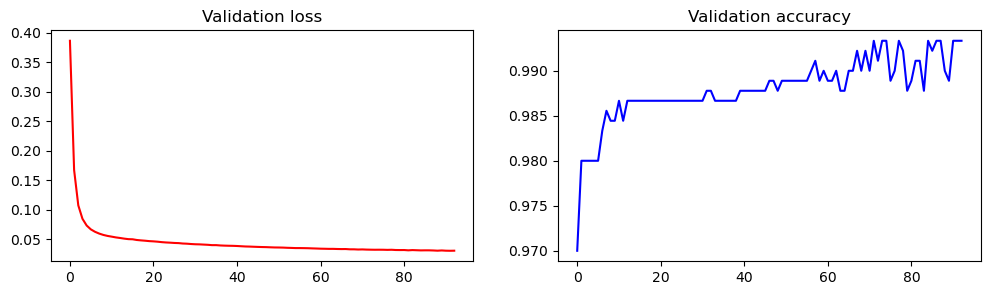

Accuracy: 0.9900
F2-score: 0.8133
Recall:   0.7941



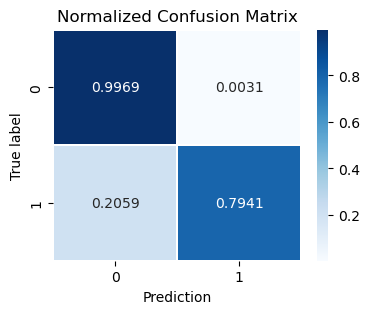

In [12]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'mlp_cfg1-all_features')

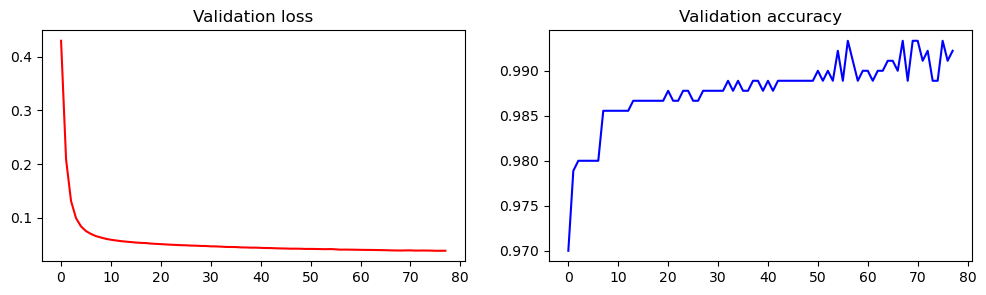

Accuracy: 0.9800
F2-score: 0.7670
Recall:   0.7941



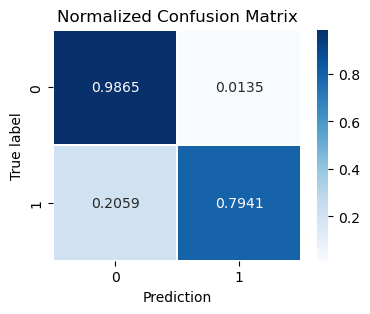

In [13]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'mlp_cfg1-reduced_features') 

### Configuration - 2

In [14]:
classifier = MLPClassifier(
    hidden_layer_sizes=(32, 32),
    activation='relu',
    solver='adam',
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=0
)

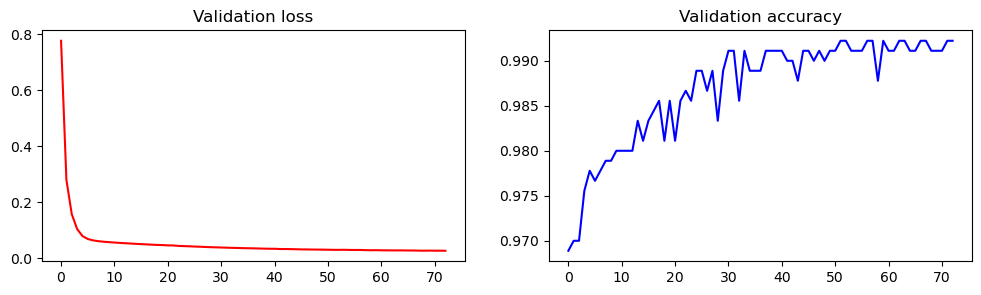

Accuracy: 0.9910
F2-score: 0.8182
Recall:   0.7941



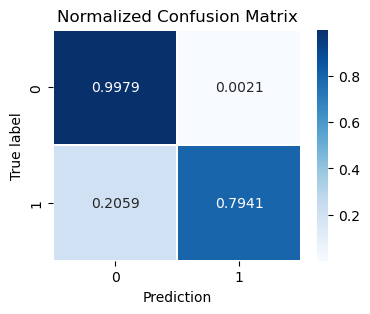

In [15]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'mlp_cfg2-all_features')

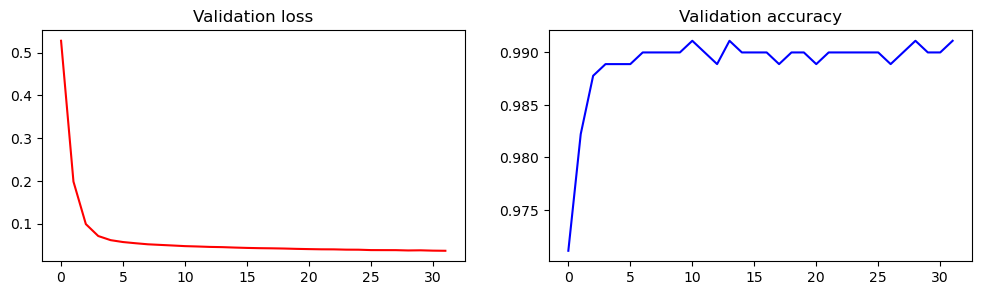

Accuracy: 0.9800
F2-score: 0.7670
Recall:   0.7941



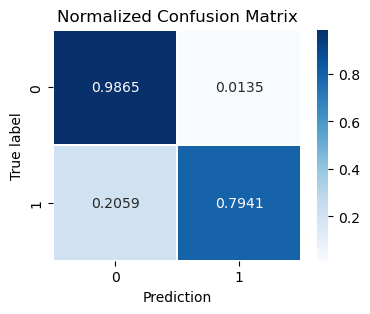

In [16]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'mlp_cfg2-reduced_features') 

### Configuration - 3

In [17]:
classifier = MLPClassifier(
    hidden_layer_sizes=(16, 8),
    activation='relu',
    solver='adam',
    alpha=1e-3,
    learning_rate_init=1e-3,
    max_iter=1000,
    tol=1e-4,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=20,
    random_state=0
)

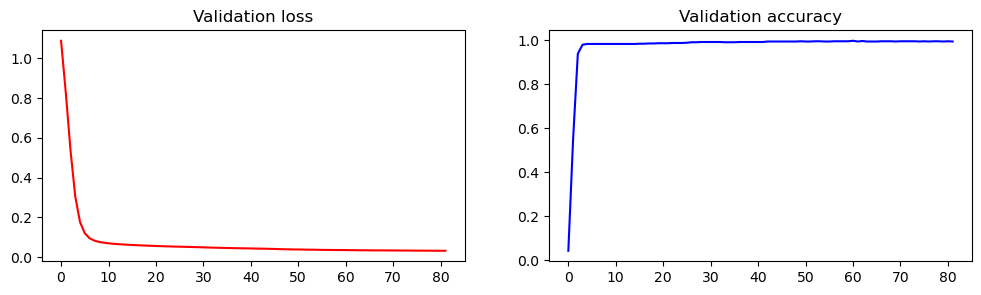

Accuracy: 0.9870
F2-score: 0.7988
Recall:   0.7941



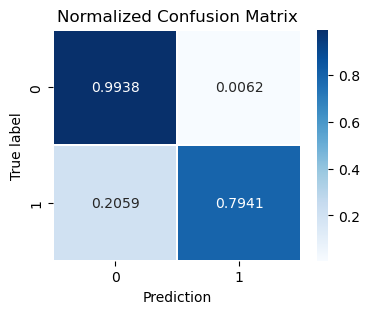

In [18]:
feature_set = features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'mlp_cfg3-all_features')

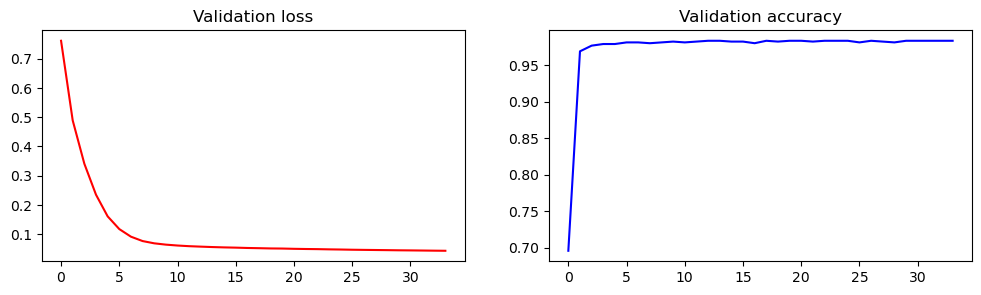

Accuracy: 0.9780
F2-score: 0.7584
Recall:   0.7941



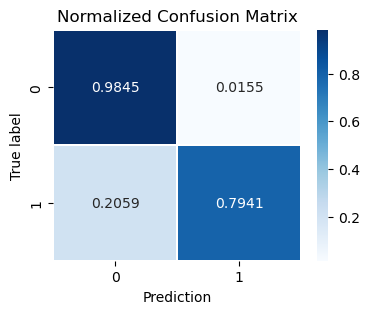

In [19]:
feature_set = reduced_features
tuned_model = fit_model(classifier, feature_set)
evaluate_model(tuned_model, feature_set)
save_model(tuned_model, 'mlp_cfg3-reduced_features') 